# Rekurencyjne Sieci Neuronowe (RNN)
### Importy

In [1]:
%matplotlib inline

# imports 
import torch
from torch import nn
from torch.nn.functional import cross_entropy

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import numpy as np
import matplotlib.pyplot as plt 
from typing import Tuple, Optional

## Dane sekwencyjne

Modele, którymi zajmowaliśmy się wcześniej zakładały konkretny kształt danych. Dla przykładu klasyczna sieć neuronowa fully-connected zakładała, że na wejściu dostanie wektory rozmiaru $784$ - dla wektorów o innej wymiarowości i innych obiektów model zwyczajnie nie będzie działać.

Takie założenie bywa szczególnie niewygodne przy pracy z niektórymi typami danych, takimi jak:
* językiem naturalny (zdania nie mają zadanej z góry liczby słów)
* szeregi czasowe (dane giełdowe ciągną się właściwie w nieskończoność) 
* dźwięk (nagrania mogą być krótsze lub dłuższe).

Do rozwiązania tego problemu służą rekuencyjne sieci neuronowe (*recurrent neural networks, RNNs*), które zapamiętują swój stan z poprzedniej iteracji.

### Ładowanie danych
Na tych zajęciach będziemy traktować cyfry z MNISTa jako dane sekwencyjne, gdzie w danym kroku czasowym $T$ obserwujemy $T$-ty wiersz pikseli z cyfry.

In [2]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))])

train_data = MNIST(root='.', train=True, transform=transforms, download=True)
test_data = MNIST(root='.', train=False, transform=transforms)

## Zadanie 1. (2 pkt.)

Zaimplementuj "zwykłą" sieć rekurencyjną. 
![rnn](resources/rnn.png)

* W klasie `RNN` należy zainicjalizować potrzebne wagi oraz zaimplementować główną logikę dla pojedynczej chwili czasowej $x_t$
* Wyjście z sieci możemy mieć dowolny rozmiar, potrzebna jest również warstwa przekształacjąca stan ukryty na wyjście.
* W pętli uczenia należy dodać odpowiednie wywołanie sieci. HINT: pamiętać o iterowaniu po wymiarze "czasowym".


In [15]:
class RNN(nn.Module):
    
    def __init__(self, 
                 input_size: int,
                 hidden_size: int, 
                 output_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        :param output_size: int
            Desired dimensionality of the output vector
        """
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.input_to_hidden = nn.Sequential(nn.Linear(input_size + hidden_size, hidden_size), nn.ReLU()) 
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
    
    # for the sake of simlicity a single forward will process only a single timestamp 
    def forward(self, 
                input: torch.tensor, 
                hidden: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        :param hidden: torch.tensor
            Representation of the memory of the RNN from previous timestep
            shape [batch_size, hidden_size]
        """
        
        combined = torch.cat([input, hidden], dim=1) 
        hidden = self.input_to_hidden(combined)
        output = self.hidden_to_output(hidden)
        return output, hidden
    
    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Returns initial value for the hidden state
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

### Pętla uczenia

In [17]:
torch.manual_seed(1337)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize network and optimizer
rnn = RNN(28, 64, 10)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   

# we will train for only a single epoch 
epochs = 1

# main loop
grads = list()
for epoch in range(epochs):
    
    for i, (x, y) in enumerate(train_loader):  
        
        optimizer.zero_grad()
        # get initial hidden state
        hidden = rnn.init_hidden(x.shape[0])
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the 2nd, time dimensiotn
        
        # YOUR CODE HERE 
        seq_len = x.shape[1]
        hiddens = list()
        for j in range(seq_len):
            output, hidden = rnn(x[:,j], hidden)
            hidden.retain_grad()
            hiddens.append(hidden)
            
        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()  
        
        grads.append([np.linalg.norm(h.grad.numpy()) for h in hiddens])
        
        if i % 100 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss}")

# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):

        hidden = rnn.init_hidden(x.shape[0])
        seq_len = x.shape[1]
        for j in range(seq_len):
            output, hidden = rnn(x[:,j], hidden)

        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))

    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.4, "Subject to random seed you should get over 0.4 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.3104450702667236
Epoch: 0 Iter: 101/1200 Loss: 1.5035297870635986
Epoch: 0 Iter: 201/1200 Loss: 1.2872183322906494
Epoch: 0 Iter: 301/1200 Loss: 1.5767641067504883
Epoch: 0 Iter: 401/1200 Loss: 0.9259627461433411
Epoch: 0 Iter: 501/1200 Loss: 0.7096347212791443
Epoch: 0 Iter: 601/1200 Loss: 1.130979061126709
Epoch: 0 Iter: 701/1200 Loss: 1.019309639930725
Epoch: 0 Iter: 801/1200 Loss: 0.5484327077865601
Epoch: 0 Iter: 901/1200 Loss: 0.5212410092353821
Epoch: 0 Iter: 1001/1200 Loss: 1.468489408493042
Epoch: 0 Iter: 1101/1200 Loss: 0.6718148589134216
Final Accuracy: 0.7926


## Zadanie 2 (2 pkt.)
Dopisz kod do powyższej pętli, który zbiera gradienty po kolejnych stanach ukrytych dla przykładu. Spójrz na wykres przedstawiający normy kolejnych gradientów i spróbuj zinterpretować wyniki, które widzisz. 

**Hint implementacyjny**: dla MNISTa mamy 28 kroków (więc 28 norm gradientów dla każdego przykładu).  

**Ważne:** Ponieważ normalnie w torchu czyścimy wszystkie gradienty po każdej iteracji aby je zachować w dla niektórych wag przydatna będzie metoda [`retain_grad`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.retain_grad).

<BarContainer object of 28 artists>

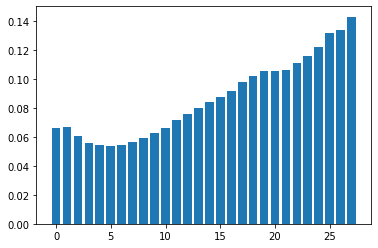

In [18]:
# mean_grads in assume to be a 1D array or list of average gradients norm per timestep memory 
mean_grads = torch.mean(torch.Tensor(grads),0)

plt.bar(x=np.arange(len(mean_grads)), height=mean_grads)

## Zadanie 3 (3 pkt.)
Ostatnim zadaniem jest implementacji komórki i sieci LSTM. 

![lstm](resources/lstm.png)

* W klasie `LSTMCell` ma znaleźć się główna loginka LSTMa, czyli wszystkie wagi do stanów `hidden` i `cell` jak i bramek kontrolujących te stany. 
* W klasie `LSTM` powinno znaleźć się wywołanie komórki LSTM, HINT: poprzednio było w pętli uczenia, teraz przenisiemy to do klasy modelu.
* W pętli uczenia należy uzupełnić brakujące wywołania do uczenia i ewaluacji modelu.

Zdecydowanie polecam [materiały Chrisa Olaha](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) do zarówno zrozumienia jak i ściągi do wzorów.

Zadaniem jest osiągnięcie dokładności na poziomie przynajmniej 90%, przy prawidłowej implementacji nie powinno być z tym problemów używając podanych hiperparametrów. Dozwolona jest oczywiście zmiana `random seed`.

#### Komórka LSTM

In [6]:
class LSTMCell(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTMCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        # initialize LSTM weights 
        # NOTE: there are different approaches that are all correct 
        # (e.g. single matrix for all input opperations), you can pick
        # whichever you like for this task
    
        ???

    def forward(self, 
                input: torch.tensor, 
                states: Tuple[torch.tensor, torch.tensor]) -> Tuple[torch.tensor, torch.tensor]:
        
        hidden, cell = states
        
        # Compute input, forget, and output gates
        # then compute new cell state and hidden state
        # see http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
        
        cell = ???
        
        hidden = ???
        
        return hidden, cell

### Klasa modelu LSTM

In [7]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell = LSTMCell(input_size=input_size, hidden_size=hidden_size)
        
    def forward(self, 
                input: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        Returns Tuple of two torch.tensors, both of shape [seq_len, batch_size, hidden_size]
        """
        
        batch_size = input.shape[0]
        
        initial_states = self.init_hidden_cell(batch_size)
        
        hiddens = []
        cells = []
        
        hidden, cell = initial_states

        # this time we will process the whole sequence in the forward method
        # as oppose to the previous exercise, remember to loop over the timesteps
        
        time_steps = input.shape[1]
        
        
        hiddens = ???
        cells = ???

        return hiddens, cells
    
    def init_hidden_cell(self, batch_size):
        """
        Returns initial value for the hidden and cell states
        """
        return (torch.zeros(batch_size, self.hidden_size, requires_grad=True), 
                torch.zeros(batch_size, self.hidden_size, requires_grad=True))

### Pętla uczenia

In [ ]:
from itertools import chain

torch.manual_seed(1337)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize the lstm with an additional cliassifier layer at the top
lstm = LSTM(input_size=28, hidden_size=64)
clf = nn.Linear(in_features=64, out_features=10)

# initialize a optimizer
params = chain(lstm.parameters(), clf.parameters())
optimizer = torch.optim.Adam(params, lr=0.01) 

# we will train for only a single epoch 
epoch = 1

# main loop
for epoch in range(epoch):
    
    for i, (x, y) in enumerate(train_loader):        
        
        optimizer.zero_grad()
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the sequence length here
        
        output = ???
        # calucate the loss
        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()                                
        
        if i % 50 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss:.4f}")

# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):
        
        output = ???

        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))
    
    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.9, "Subject to random seed you should get over 0.9 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.3939
Epoch: 0 Iter: 51/1200 Loss: 2.1830
Epoch: 0 Iter: 101/1200 Loss: 1.6664
Epoch: 0 Iter: 151/1200 Loss: 1.4374
Epoch: 0 Iter: 201/1200 Loss: 1.4193
Epoch: 0 Iter: 251/1200 Loss: 1.2045
Epoch: 0 Iter: 301/1200 Loss: 0.9174
Epoch: 0 Iter: 351/1200 Loss: 1.0483
Epoch: 0 Iter: 401/1200 Loss: 1.0119
Epoch: 0 Iter: 451/1200 Loss: 0.6014
Epoch: 0 Iter: 501/1200 Loss: 0.6967
Epoch: 0 Iter: 551/1200 Loss: 0.3628
Epoch: 0 Iter: 601/1200 Loss: 0.5102
Epoch: 0 Iter: 651/1200 Loss: 0.4934
Epoch: 0 Iter: 701/1200 Loss: 0.6267
Epoch: 0 Iter: 751/1200 Loss: 0.3685
Epoch: 0 Iter: 801/1200 Loss: 0.3376
